In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import path
from dataclasses import dataclass

In [2]:
plt.rc('font', family='Pretendard')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
preview_count = 10
batch_size = 100
output_classes = 10
lr = 0.01
epochs = 20

print(f"다음 device로 학습합니다: {device}")

다음 device로 학습합니다: cpu


In [3]:
class MNISTDataset(Dataset):
    def __init__(self, dataset_path: str):
        df = pd.read_csv(dataset_path)

        self.X = torch.Tensor(df.drop(columns=['label']).values).reshape((-1, 1, 28, 28)).to(device)
        self.Y = torch.LongTensor(df['label']).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx) -> tuple:
        return self.X[idx], self.Y[idx].item()

    @property
    def shape(self):
        return self.X.shape, self.Y.shape

    @property
    def data_shape(self):
        return self.X.shape[1:]

In [5]:
mnist_train = MNISTDataset("../data/mnist_train.csv")
print(mnist_train.shape)
print(mnist_train.data_shape)

mnist_test = MNISTDataset("../data/mnist_test.csv")
print(mnist_test.shape)
print(mnist_test.data_shape)

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))
torch.Size([1, 28, 28])
(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))
torch.Size([1, 28, 28])


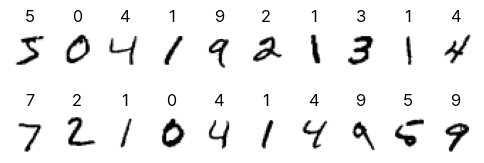

In [6]:
fig, axis = plt.subplots(2, preview_count, figsize=(6, 2))

for i in range(preview_count):
    ith_data = mnist_train[i]

    axis[0, i].set_axis_off()
    axis[0, i].imshow(ith_data[0].cpu().view((28, 28)), cmap='gray_r')
    axis[0, i].set_title(ith_data[1])

for i in range(preview_count):
    ith_data = mnist_test[i]

    axis[1, i].set_axis_off()
    axis[1, i].imshow(ith_data[0].cpu().view((28, 28)), cmap='gray_r')
    axis[1, i].set_title(ith_data[1])

In [10]:
data_loader = DataLoader(
    dataset=mnist_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

model = nn.Sequential(
    # [batch 1 28 28] -> [batch 32 28 28]
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    # [batch 32 28 28] -> [batch 32 14 14]
    nn.MaxPool2d(kernel_size=2, stride=2),

    # [batch 32 14 14] -> [batch 64 14 14]
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    # [batch 64 14 14] -> [batch 64 7 7]
    nn.MaxPool2d(kernel_size=2, stride=2),

    # [batch 64 7 7] -> [batch 64*7*7]
    nn.Flatten(1, 3),

    # [batch 64*7*7] -> [batch 10]
    nn.Linear(64*7*7, output_classes),

    nn.Softmax(dim=1).float()
).to(device)

cost = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
next(iter(data_loader))[0].shape

torch.Size([100, 1, 28, 28])

In [12]:
for epoch in range(epochs):
    average_cost_of_batch = 0.0

    for X, Y in data_loader:    # iterate for batch_size
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()

        predicted = model(X).to(device)
        current_cost = cost(predicted, Y)

        current_cost.backward()
        optimizer.step()

        average_cost_of_batch += current_cost

    print(f"Epoch {epoch + 1:02}/{epochs}, cost = {average_cost_of_batch / batch_size}")

Epoch 01/20, cost = 14.092619895935059
Epoch 02/20, cost = 14.092720031738281
Epoch 03/20, cost = 14.092720985412598
Epoch 04/20, cost = 14.0927152633667
Epoch 05/20, cost = 14.092713356018066
Epoch 06/20, cost = 14.092721939086914
Epoch 07/20, cost = 14.092718124389648
Epoch 08/20, cost = 14.092717170715332
Epoch 09/20, cost = 14.09271240234375
Epoch 10/20, cost = 14.092718124389648
Epoch 11/20, cost = 14.092703819274902
Epoch 12/20, cost = 14.0927152633667
Epoch 13/20, cost = 14.092708587646484
Epoch 14/20, cost = 14.092711448669434
Epoch 15/20, cost = 14.0927152633667
Epoch 16/20, cost = 14.0927152633667
Epoch 17/20, cost = 14.092713356018066
Epoch 18/20, cost = 14.092708587646484
Epoch 19/20, cost = 14.092721939086914
Epoch 20/20, cost = 14.092711448669434


model accuracy: 11.35%


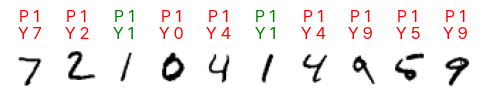

In [13]:
with torch.no_grad():
    X_test = mnist_test.X
    Y_test = mnist_test.Y

    predicted = torch.argmax(model(X_test), dim=1)
    is_correct = (predicted == Y_test)

    print(f"model accuracy: {is_correct.float().mean() * 100:.2f}%")

    fig, axis = plt.subplots(1, preview_count, figsize=(6, 1))

    for i in range(preview_count):
        ith_data = mnist_test[i]

        axis[i].set_axis_off()
        axis[i].imshow(ith_data[0].cpu().view((28, 28)), cmap='gray_r')
        axis[i].set_title(f'P {predicted[i].item()}\nY {ith_data[1]}',
                          color=('green' if predicted[i].item() == ith_data[1] else 'red'))